In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os

import PlaceCellAnalysis as pc
import utilities as u
import preprocessing as pp
import behavior as b
import BayesianDecoding as bd


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
mice = ['4139190.1','4139190.3','4139212.2','4139219.2','4139219.3','4139224.2','4139224.3','4139224.5']
df = pp.load_session_db()
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])

In [3]:
mouse = '4139219.2'

In [5]:
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')]

sess = df_mouse.iloc[10]
VRDat,C, S, A = pp.load_scan_sess(sess)
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
#S_trial_mat, occ, edges, centers = u.make_pos_bin_trial_matrices(S,VRDat.pos._values,tstart_inds,teleport_inds,speed=VRDat.speed._values)
C_trial_mat, occ, edges, centers = u.make_pos_bin_trial_matrices(C,VRDat.pos._values,tstart_inds,teleport_inds,speed=VRDat.speed._values)


G:\My Drive\2P_Data\TwoTower\4139219.2\23_10_2018\TwoTower_Timeout\TwoTower_Timeout_002_011.mat


C:\Users\mplitt\MightyMorphingPhotonRangers\preprocessing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame['ca inds'] = caInds
C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcas

G:\My Drive\2P_Data\TwoTower\4139219.2\23_10_2018\TwoTower_Timeout\TwoTower_Timeout_002_011.mat
#subsystem#not made into numpy array
Anot made into numpy array
frame diff 0


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:255: RuntimeWarning: Mean of empty slice
  zone0_speed[i]=np.nanmean(sub_frame.loc[zone0_mask,'speed'])
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:256: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:75: RuntimeWarning: invalid value encountered in greater
  if np.where((position>edge1) & (position<=edge2))[0].shape[0]>0:
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:75: RuntimeWarning: invalid value encountered in less_equal
  if np.where((position>edge1) & (position<=edge2))[0].shape[0]>0:
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:76: RuntimeWarning: invalid value encountered in greater
  frmap[i] = np.nanmean(C[(position>edge1) & (position<=edge2),:],axis=0)
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:76: RuntimeWarning: invalid value encountered in less_equal
  frma

In [6]:
C_dict = u.trial_type_dict(C_trial_mat,trial_info['morphs'])


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:256: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:257: RuntimeWarning: Mean of empty slice
  wj, c = sp.stats.mode(sub_frame['wallJitter'],nan_policy='omit')
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:75: RuntimeWarning: invalid value encountered in greater
  if np.where((position>edge1) & (position<=edge2))[0].shape[0]>0:
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:75: RuntimeWarning: invalid value encountered in less_equal
  if np.where((position>edge1) & (position<=edge2))[0].shape[0]>0:
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:76: RuntimeWarning: invalid value encountered in greater
  frmap[i] = np.nanmean(C[(position>edge1) & (position<=edge2),:],axis=0)
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:76: RuntimeWarning: invalid value encountered in less_equal
  

start bootstrap
end bootstrap
start bootstrap
end bootstrap
morph 0 place cells = 296 out of 611 , 0.484452 
morph 1 place cells = 325 out of 611, 0.531915
common place cells = 173


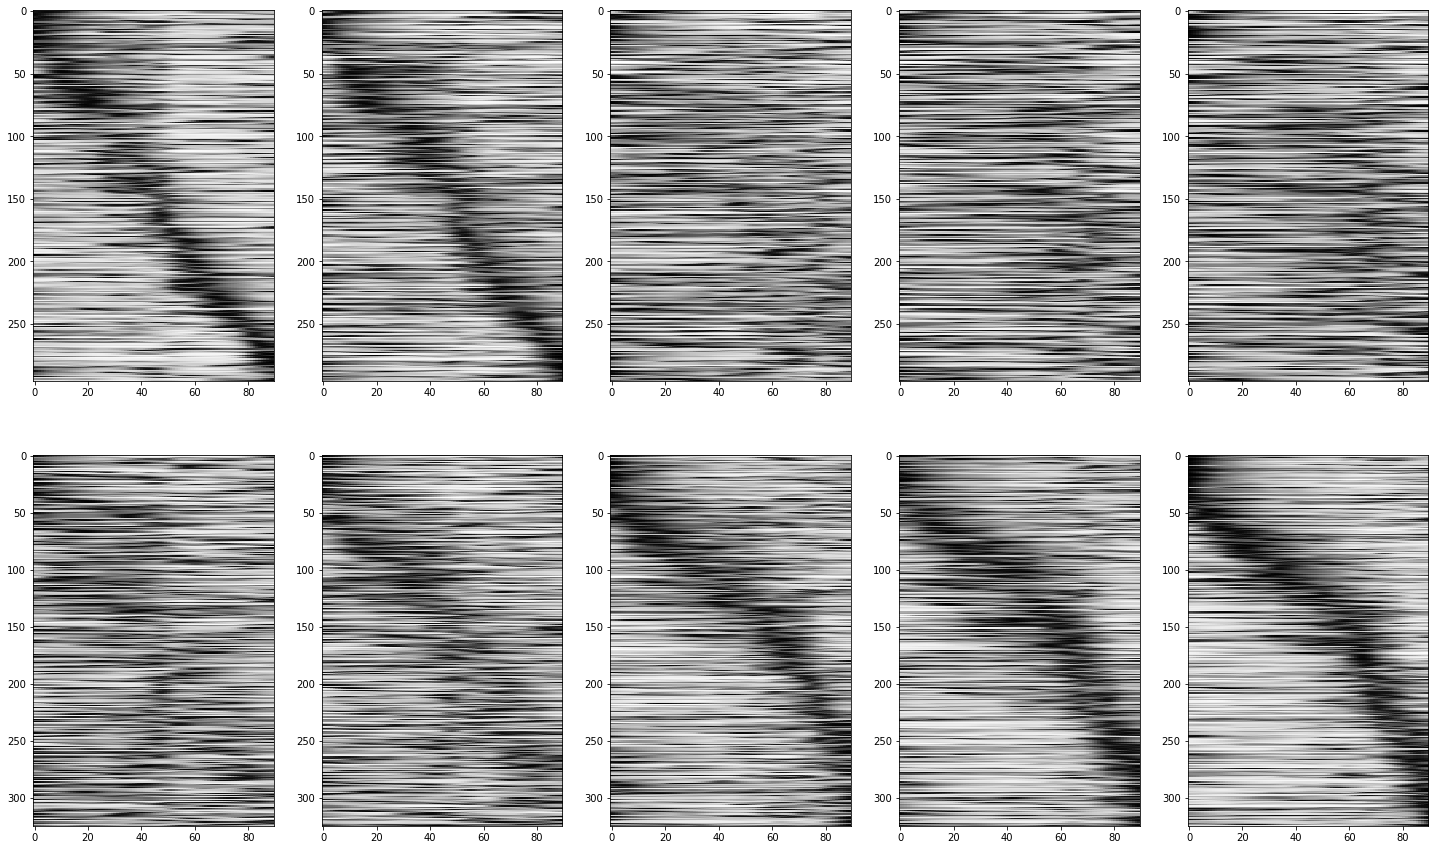

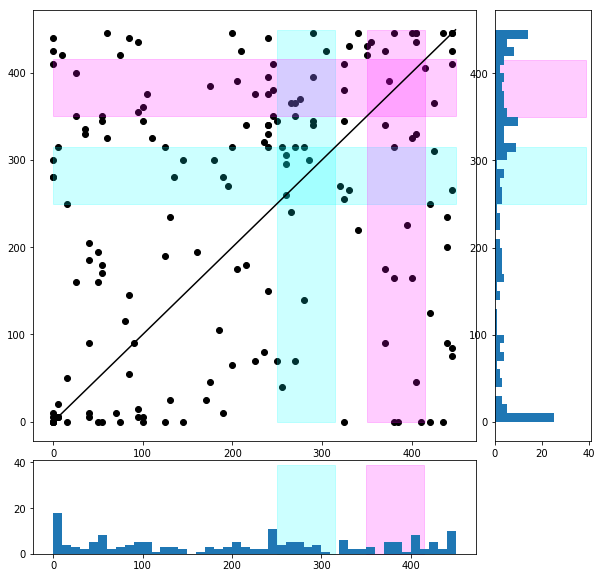

In [8]:
######### population vector correlation

# calculate place cells
FR,masks,SI = pc.single_session(sess,C=C,VRDat=VRDat)


start bootstrap
end bootstrap
start bootstrap
end bootstrap


(<Figure size 1800x1080 with 10 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025E232C1898>,
       dtype=object))

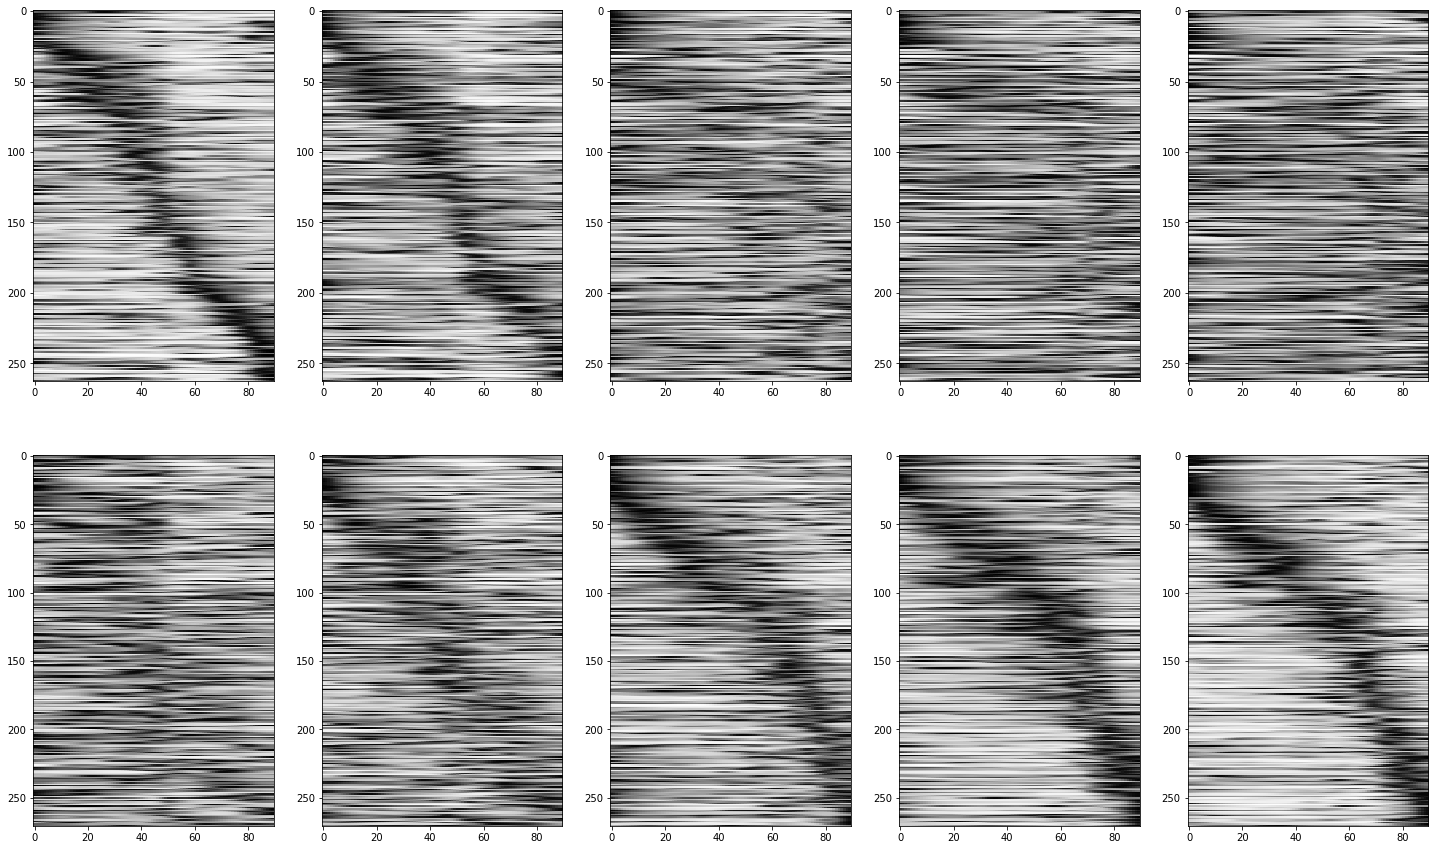

In [165]:
#print(masks[0])
masks,FR,SI=pc.place_cells_calc(C, VRDat['pos']._values,trial_info, VRDat['tstart']._values, VRDat['teleport']._values,method='bootstrap',correct_only=True)
pc.plot_placecells(C_dict,masks,cv_sort=True)

In [9]:
# get cells that have place field in two extremes
common_pc = np.multiply(masks[0],masks[1])
#common_pc = (masks[0]+masks[1])>0
FR_dict = {k:np.nanmean(v[:,:,common_pc],axis=0) for k,v in C_dict.items() if k not in ('all','labels','indices')}
remapMask = np.zeros([common_pc.sum(),])
thr = 100
for c in range(common_pc.sum()):
    shift = np.abs(np.argmax(FR_dict[0][:,c])-np.argmax(FR_dict[1][:,c]))*5.
    if shift>thr:
        remapMask[c]=1
    
remapMask = remapMask>0

FRrm_dict = {k:v[:,remapMask] for k,v in FR_dict.items()}

In [10]:
FR_dict = {k:np.nanmean(v[:,:,common_pc],axis=0) for k,v in C_dict.items() if k not in ('all','labels','indices')}

In [11]:
print(FR_dict[0].shape)

(90, 173)


In [17]:
FRCorrs = np.zeros([5,5,remapMask.sum()])
for i,(k,v) in enumerate(FRrm_dict.items()):
    for j,(kk,vv) in enumerate(FRrm_dict.items()):
        for n in range(remapMask.sum()):
            
#            FRCorrs[i,j,n],p = sp.stats.pearsonr(v[:,n].ravel(),vv[:,n].ravel())
            FRCorrs[i,j,n] = sp.spatial.distance.cosine(v[:,n].ravel(),vv[:,n].ravel())
            

# for i in range(5):
#     for n in range(remapMask.sum()):
#         rng = FRCorrs[i,:,n].max()-FRCorrs[i,:,n].min()
#         FRCorrs[i,:,n]/=rng

In [18]:
print(FRCorrs[4,:,100])

IndexError: index 100 is out of bounds for axis 2 with size 89

C:\Users\mplitt\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


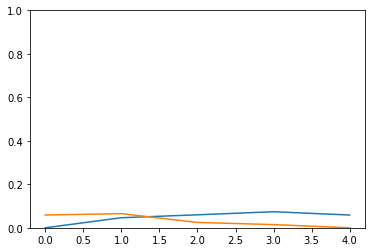

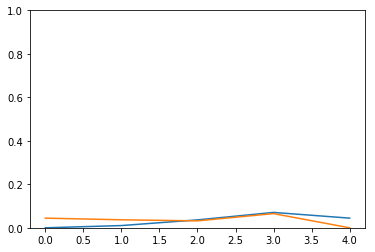

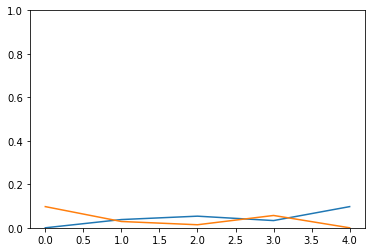

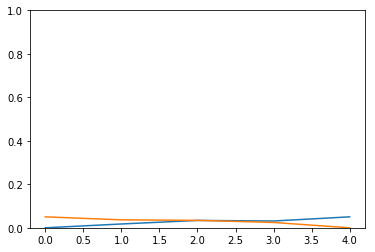

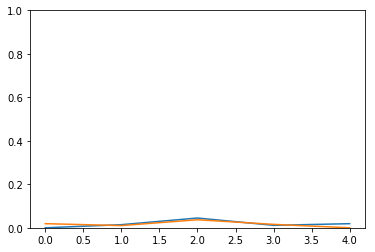

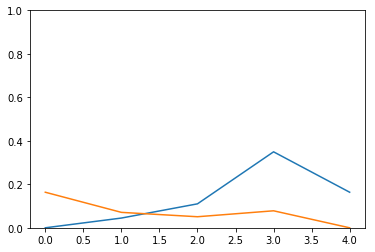

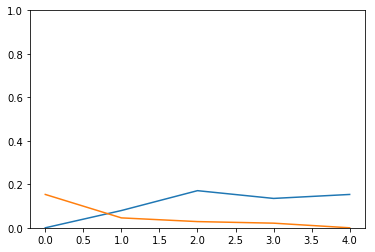

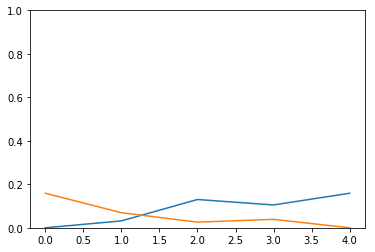

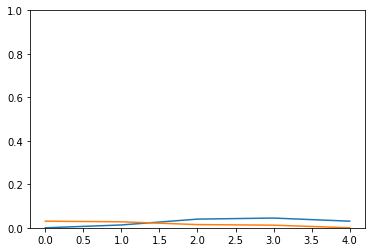

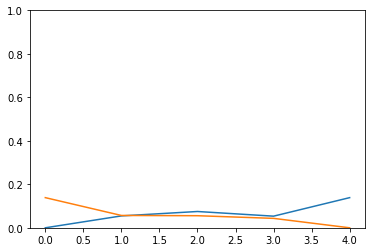

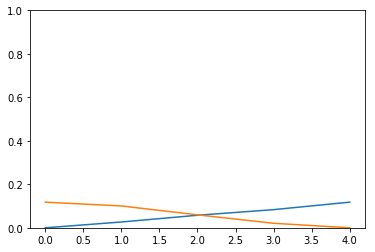

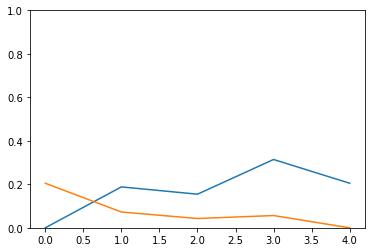

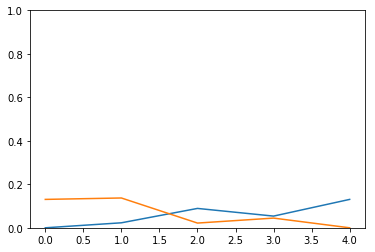

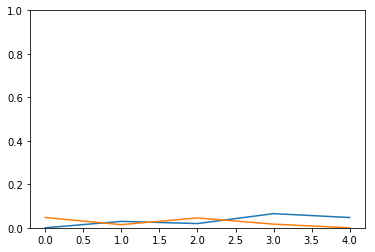

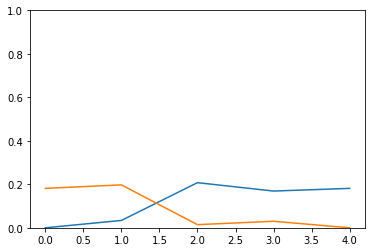

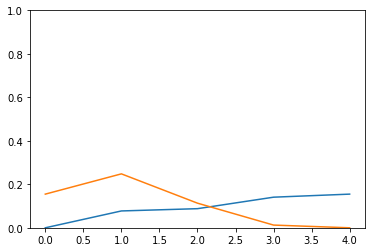

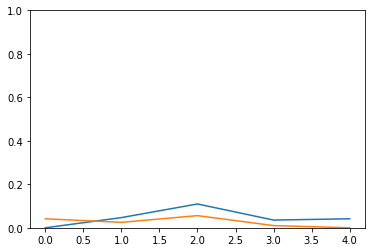

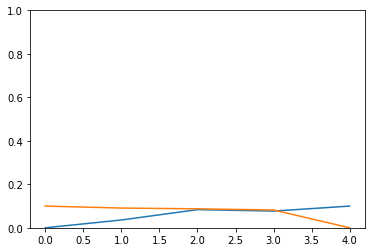

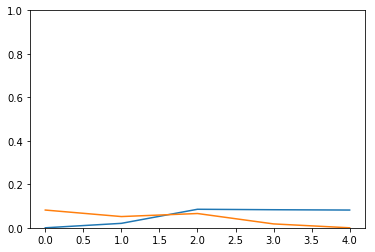

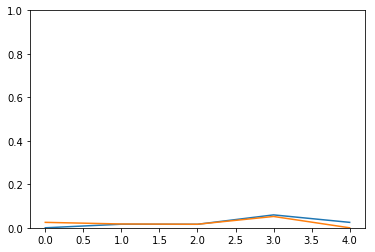

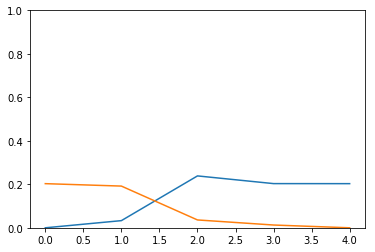

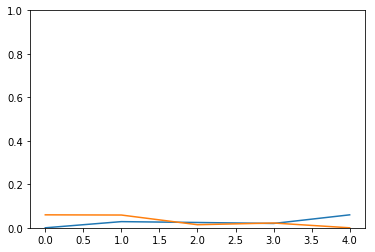

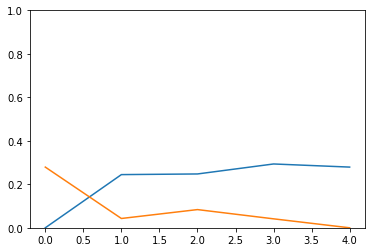

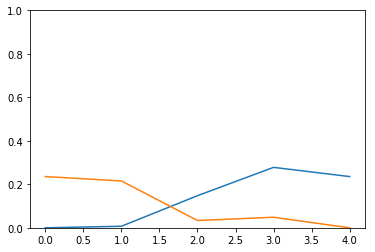

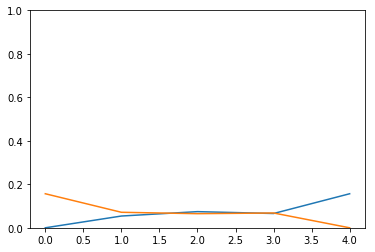

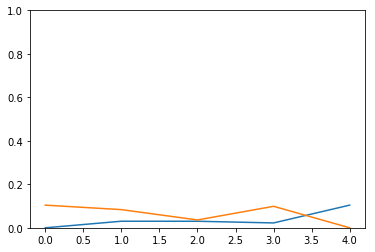

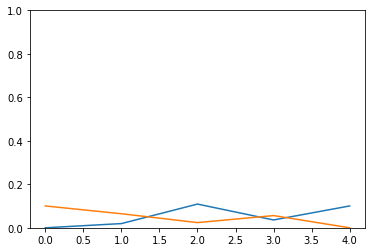

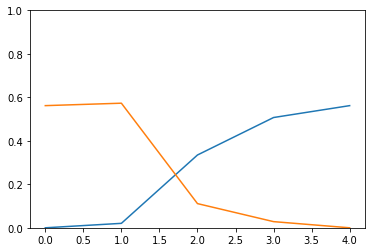

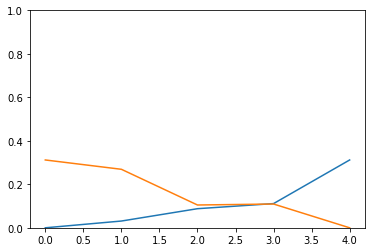

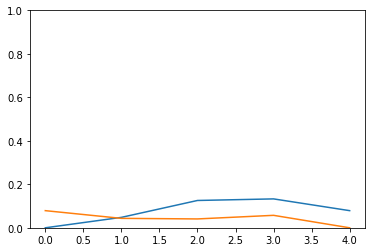

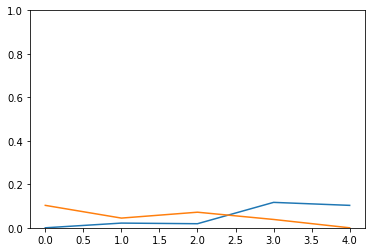

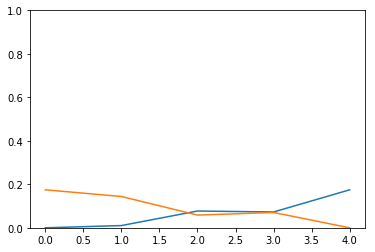

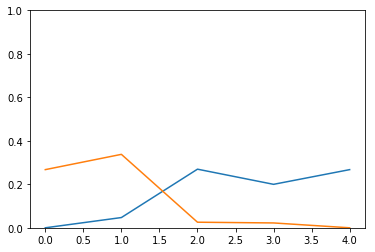

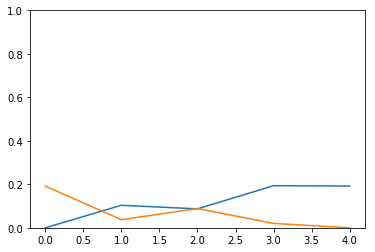

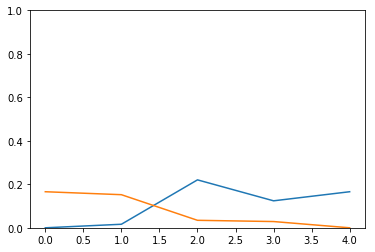

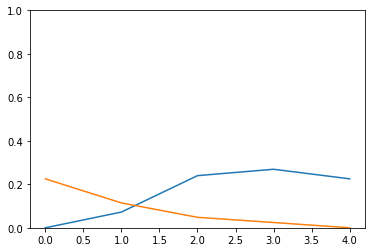

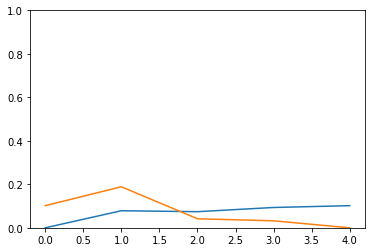

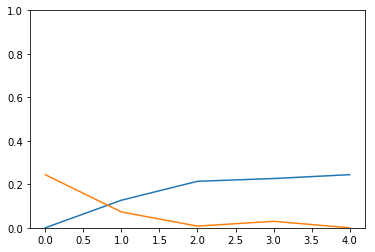

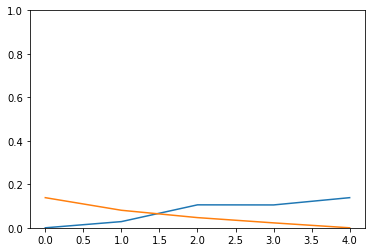

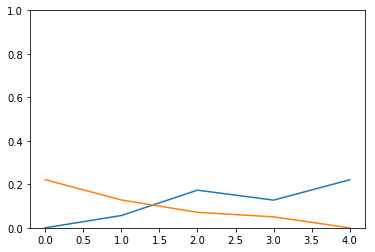

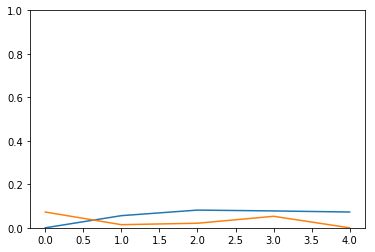

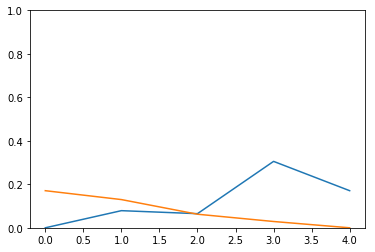

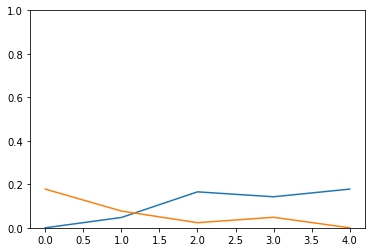

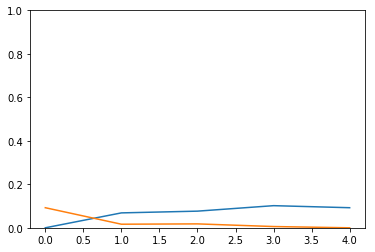

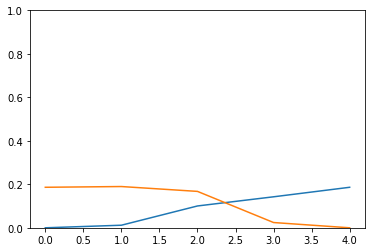

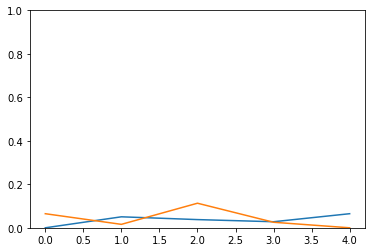

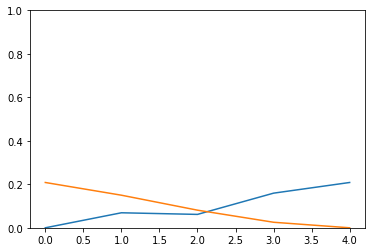

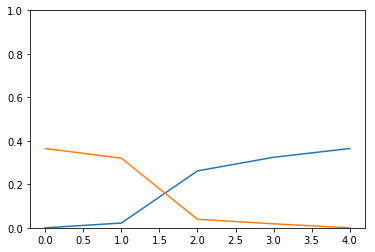

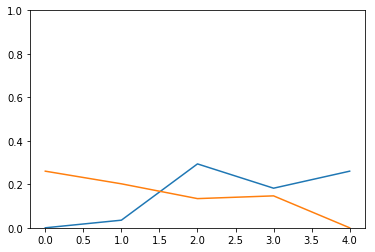

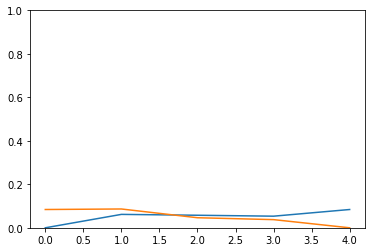

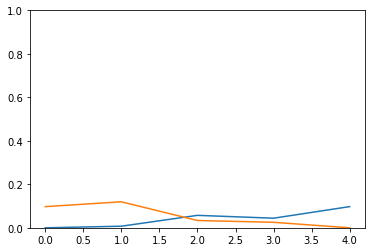

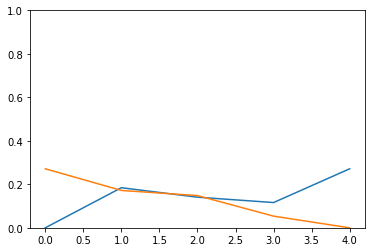

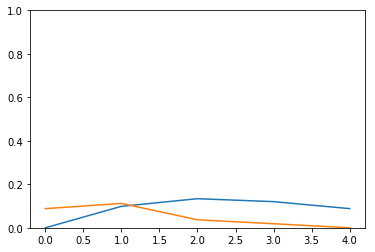

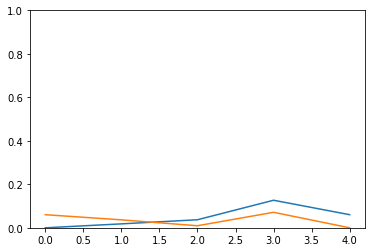

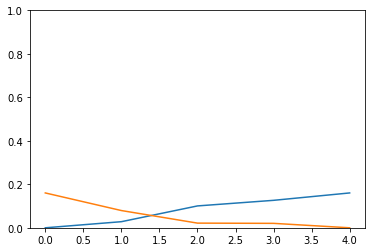

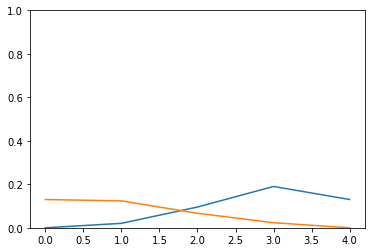

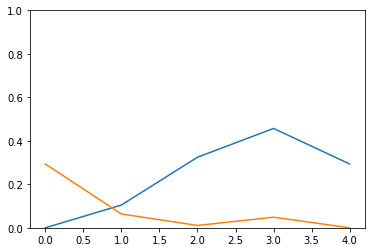

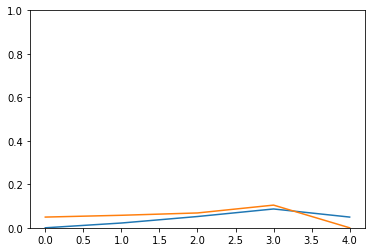

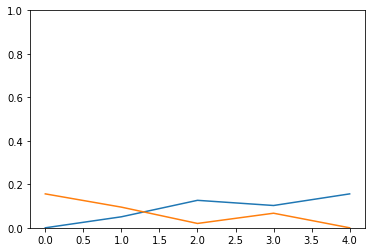

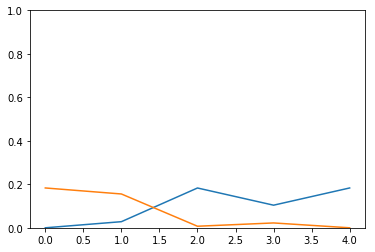

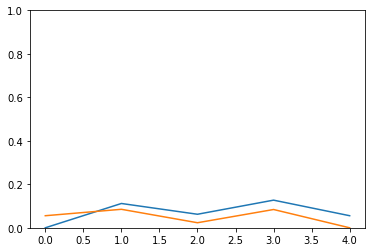

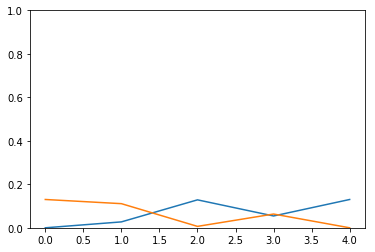

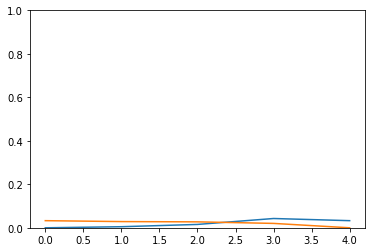

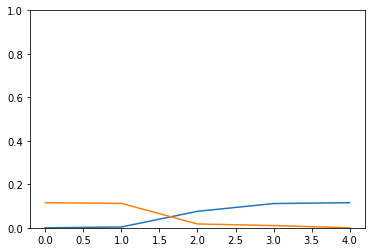

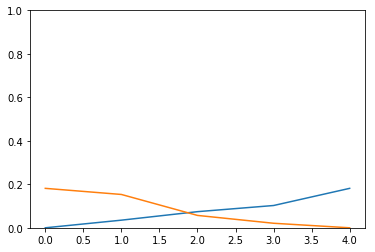

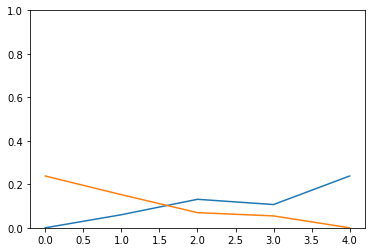

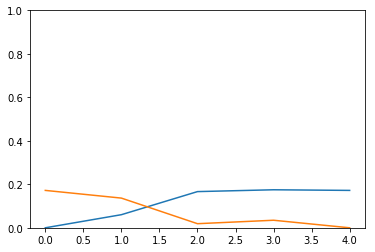

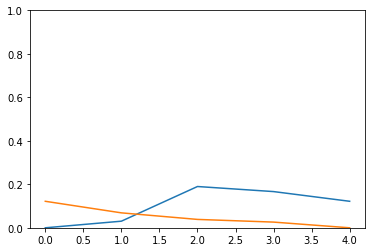

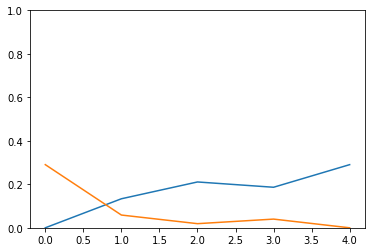

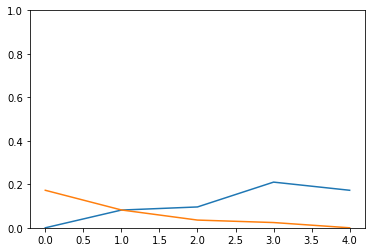

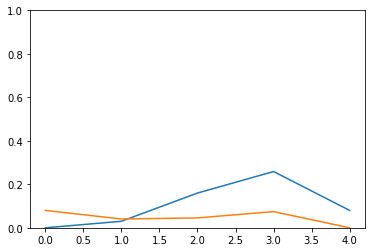

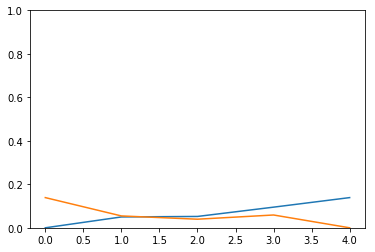

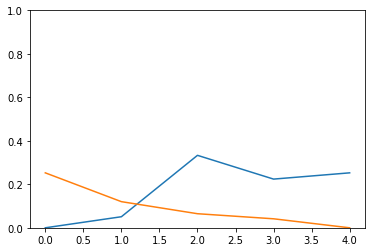

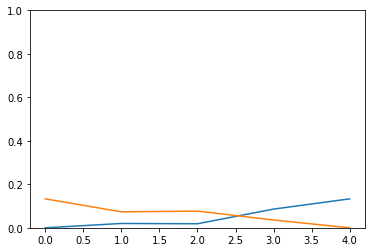

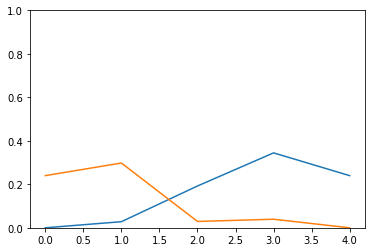

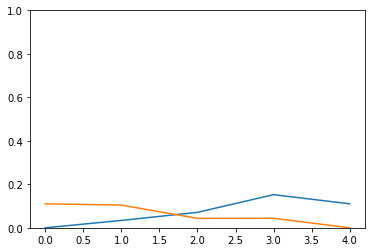

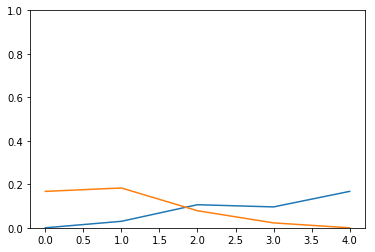

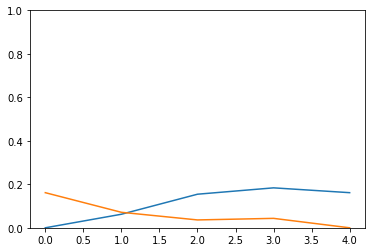

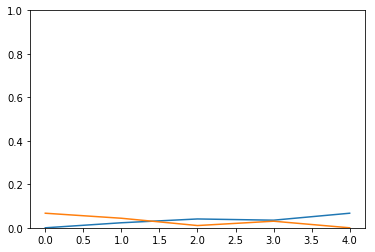

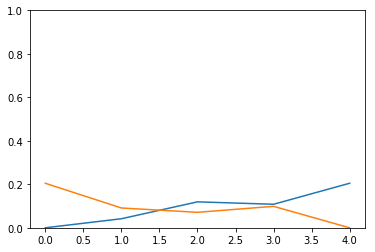

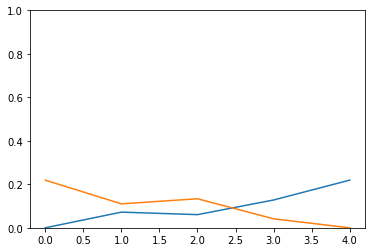

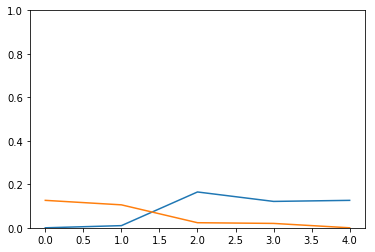

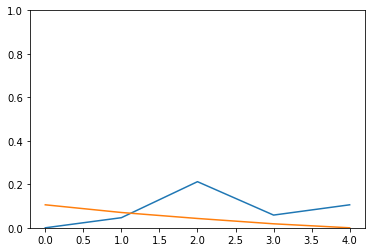

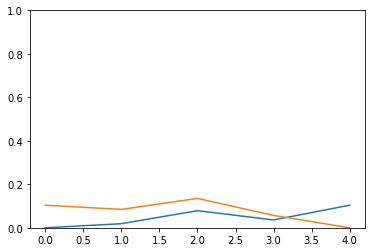

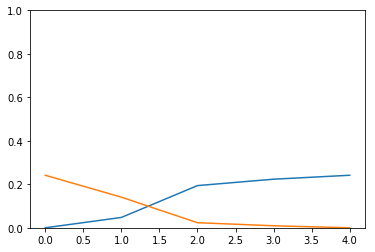

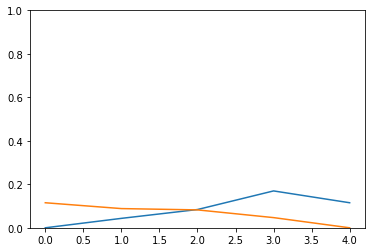

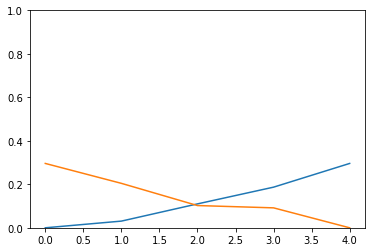

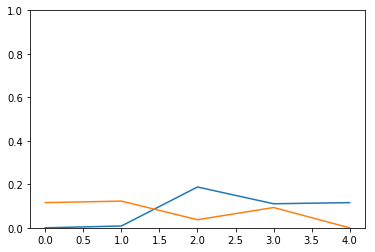

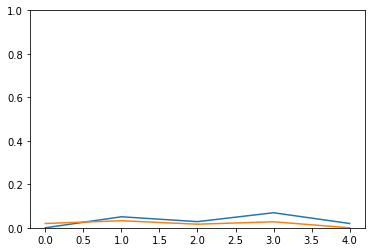

In [19]:

for n in range(0,remapMask.sum()):
    f,ax = plt.subplots()
    ax.plot(FRCorrs[0,:,n])
    ax.plot(FRCorrs[-1,:,n])
    ax.set_ylim([0,1])

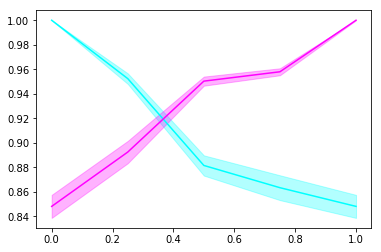

In [20]:
popmu=FRCorrs.mean(axis=-1)
popsem = sp.stats.sem(FRCorrs,axis=-1)
f, ax = plt.subplots()
m = [0.,.25,.5,.75,1]
ax.plot(m,1-popmu[0,:],color=plt.cm.cool(0.))
ax.plot(m,1-popmu[-1,:],color=plt.cm.cool(1.))
ax.fill_between(m,1-popmu[0,:]+popsem[0,:],y2=1-popmu[0,:]-popsem[0,:],color=plt.cm.cool(0.),alpha=.3)
ax.fill_between(m,1-popmu[-1,:]+popsem[-1,:],y2=1-popmu[-1,:]-popsem[-1,:],color=plt.cm.cool(1.),alpha=.3)

C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:250: RuntimeWarning: Mean of empty slice
  zone0_speed[i]=np.nanmean(sub_frame.loc[zone0_mask,'speed'])
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:251: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])


((<Figure size 360x360 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x25e071b3ef0>),
 (<Figure size 360x360 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x25e33c03080>),
 (<Figure size 360x360 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x25e13610898>))

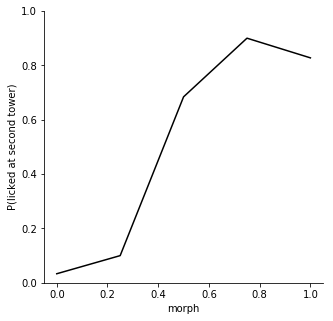

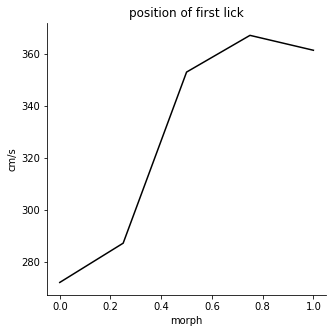

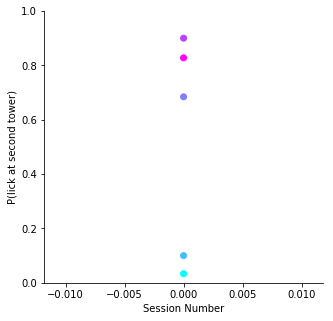

In [204]:
b.learning_curve_plots([VRDat])